# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 30
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

## Training

In [10]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    class_weight=class_weights
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 2.1359 - accuracy: 0.3530
Epoch 1: val_loss improved from inf to 50.52294, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5735s 6s/step - loss: 2.1359 - accuracy: 0.3530 - val_loss: 50.5229 - val_accuracy: 0.1400
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.9556 - accuracy: 0.4371
Epoch 2: val_loss improved from 50.52294 to 1.80582, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5349s 6s/step - loss: 1.9556 - accuracy: 0.4371 - val_loss: 1.8058 - val_accuracy: 0.4149
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.7845 - accuracy: 0.4927
Epoch 3: val_loss did not improve from 1.80582
947/947 [==============================] - 4952s 5s/step - loss: 1.7845 - accuracy: 0.4927 - val_loss: 2.5489 - val_accuracy: 0.3342
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.6953 - accuracy: 0.5006
Epoch 4: val_loss did not improve from 1.80582
947/947 [==============================] - 4953s 5s/step - loss: 1.6953 - accuracy: 0.5006 - val_loss: 2.5287 - val_accuracy: 0.3195
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.6847 - accuracy: 0.5041
Epoch 5: val_loss improved from 1.80582 to 1.58397, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5293s 6s/step - loss: 1.6847 - accuracy: 0.5041 - val_loss: 1.5840 - val_accuracy: 0.4552
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.8320 - accuracy: 0.4391
Epoch 6: val_loss did not improve from 1.58397
947/947 [==============================] - 4954s 5s/step - loss: 1.8320 - accuracy: 0.4391 - val_loss: 1.8961 - val_accuracy: 0.3920
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.8399 - accuracy: 0.4412
Epoch 7: val_loss improved from 1.58397 to 1.27391, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5340s 6s/step - loss: 1.8399 - accuracy: 0.4412 - val_loss: 1.2739 - val_accuracy: 0.5879
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.6366 - accuracy: 0.5289
Epoch 8: val_loss did not improve from 1.27391
947/947 [==============================] - 4914s 5s/step - loss: 1.6366 - accuracy: 0.5289 - val_loss: 1.5939 - val_accuracy: 0.4562
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.5928 - accuracy: 0.5350
Epoch 9: val_loss did not improve from 1.27391
947/947 [==============================] - 4957s 5s/step - loss: 1.5928 - accuracy: 0.5350 - val_loss: 4.5050 - val_accuracy: 0.2272
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.5646 - accuracy: 0.5355
Epoch 10: val_loss did not improve from 1.27391
947/947 [==============================] - 4968s 5s/step - loss: 1.5646 - accuracy: 0.5355 - val_loss: 1.3792 - val_accuracy: 0.5112
Epoch 11/30
947/947 [================

947/947 [==============================] - 5448s 6s/step - loss: 1.5049 - accuracy: 0.5451 - val_loss: 1.1632 - val_accuracy: 0.5826
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.4555 - accuracy: 0.5605
Epoch 12: val_loss did not improve from 1.16318
947/947 [==============================] - 5151s 5s/step - loss: 1.4555 - accuracy: 0.5605 - val_loss: 2.5099 - val_accuracy: 0.3675
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 1.4365 - accuracy: 0.5583
Epoch 13: val_loss improved from 1.16318 to 1.04112, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5966s 6s/step - loss: 1.4365 - accuracy: 0.5583 - val_loss: 1.0411 - val_accuracy: 0.6385
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5760
Epoch 14: val_loss did not improve from 1.04112
947/947 [==============================] - 5156s 5s/step - loss: 1.3794 - accuracy: 0.5760 - val_loss: 1.0958 - val_accuracy: 0.6237
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.5521
Epoch 15: val_loss did not improve from 1.04112
947/947 [==============================] - 5098s 5s/step - loss: 1.4189 - accuracy: 0.5521 - val_loss: 1.8499 - val_accuracy: 0.4330
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 1.3808 - accuracy: 0.5644
Epoch 16: val_loss did not improve from 1.04112
947/947 [==============================] - 5060s 5s/step - loss: 1.3808 - accuracy: 0.5644 - val_loss: 1.3560 - val_accuracy: 0.5847
Epoch 17/30
947/947 [============

## Testing

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 490s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.9343378093456896,
 'basal cell carcinoma': 0.9422344325919275,
 'dermatofibroma': 0.940800943492975,
 'melanoma': 0.8055595019360572,
 'nevus': 0.9103543913713406,
 'pigmented benign keratosis': 0.9195700704843606,
 'seborrheic keratosis': 0.8477590067539277,
 'solar lentigo': 0.9098226424422198,
 'squamous cell carcinoma': 0.9287622756278158,
 'vascular lesion': 0.9642754662840747}

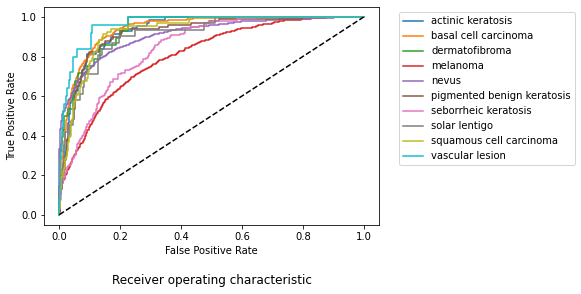

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

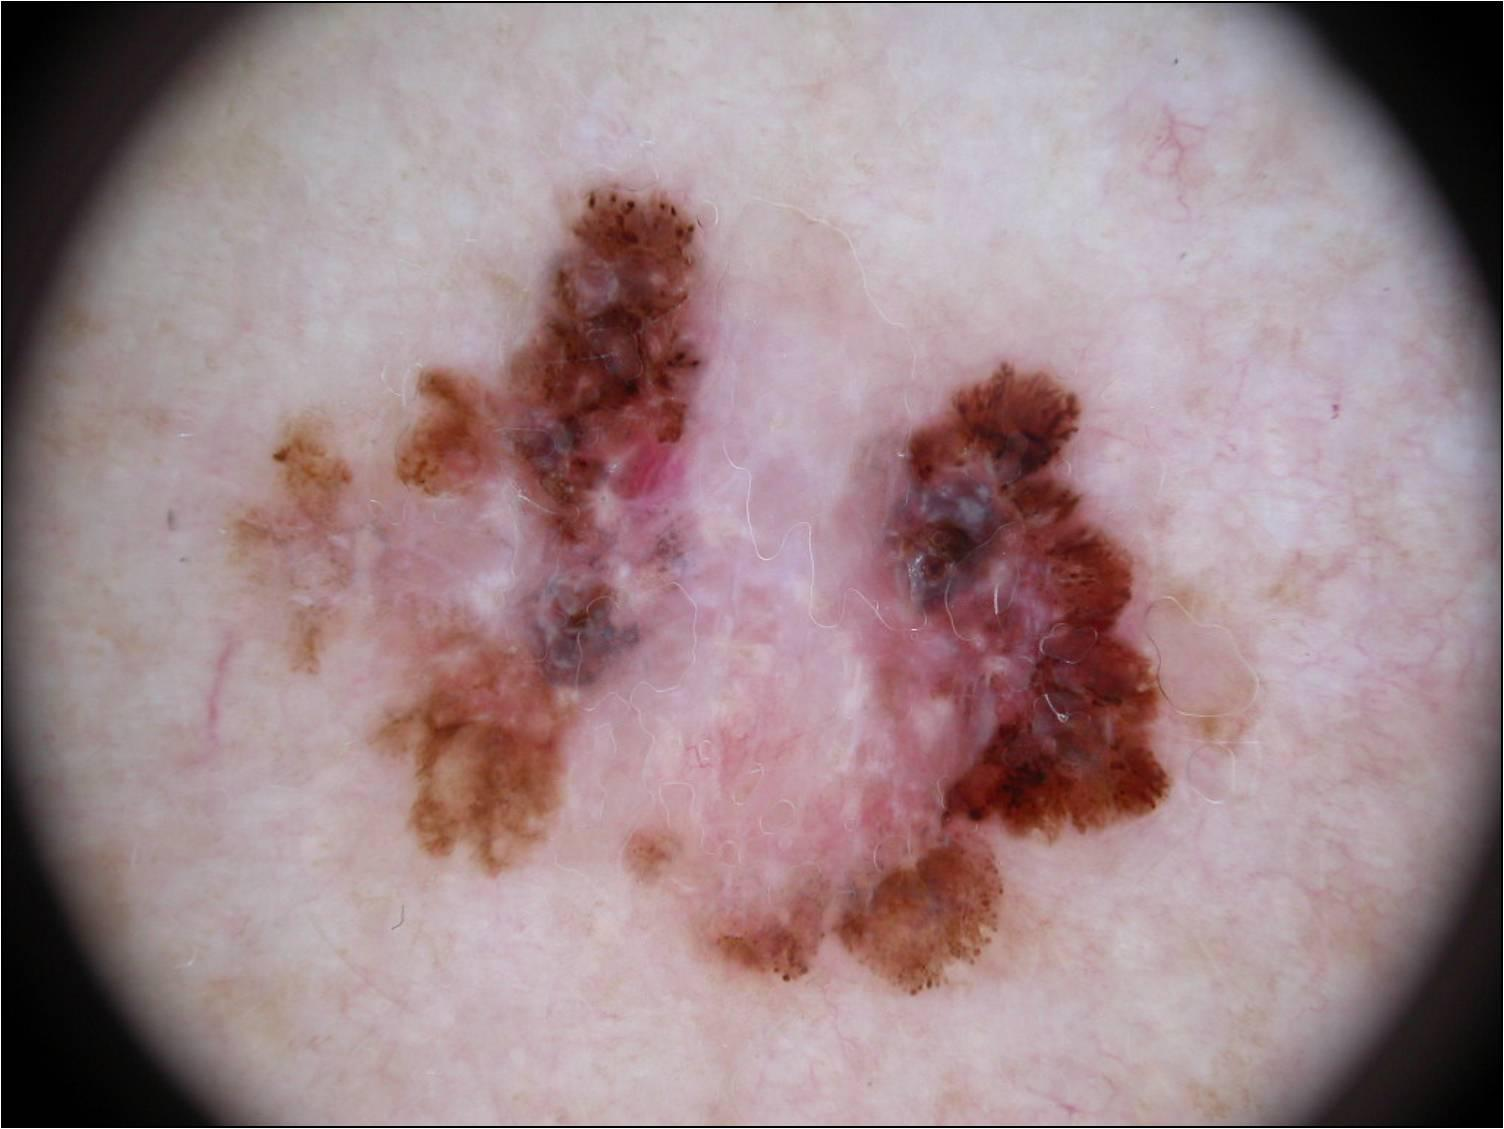

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

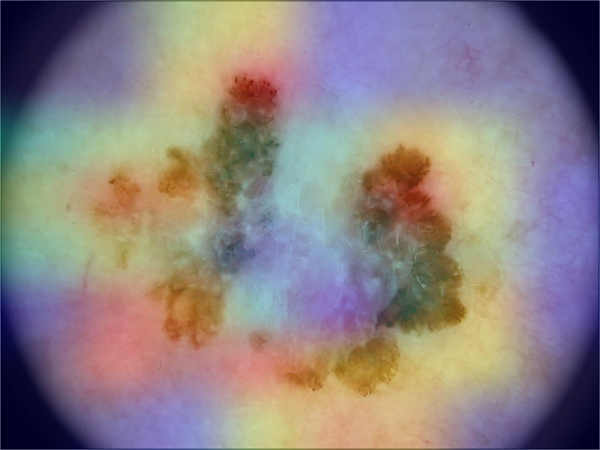

In [21]:
display_gradcam(melanoma_im_path, heatmap)